# import and mount

In [ ]:
#@title init
from google.colab import drive
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from keras.layers import AveragePooling2D, Input, Flatten, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import Model, Sequential, load_model, clone_model
from keras.utils import plot_model
import keras.applications as app
import keras.backend as K
import keras.callbacks
import tensorflow as tf
tf_session = K.get_session()
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
import matplotlib.cm as cm
import random
from PIL import Image
siz = 224
batch_size = 32
epochs = 200
steps_per_epoch = 30
data_augmentation = True
dropout_rate = 0

In [ ]:
drive.mount('/content/drive')

# load data

In [ ]:
#@title resize
# resize the image into 128*128
def resize(source):
    # row = len(source)
    # col = len(source[0])
    # source=tf.convert_to_tensor(np.array([source]))
    # source=keras.layers.MaxPooling2D(pool_size=(row//siz, col//siz))(source)
    # source=K.get_value(source)[0]
    # row = len(source)
    # col = len(source[0])
    # new = np.zeros((siz,siz,3))
    # new = np.ndarray((siz,siz,3))
    # new.fill(None)
    # for i in range(row):
    #     for j in range(col):
    #         for k in range(3):
    #             if new[int(i/row*siz)][int(j/col*siz)][k]==None:
    #                 new[int(i/row*siz)][int(j/col*siz)][k]=source[i][j][k]
    #             else:
    #                 new[int(i/row*siz)][int(j/col*siz)][k]=max(source[i][j][k],new[int(i/row*siz)][int(j/col*siz)][k])
    source=np.array(source)
    if source.max()<=1:
        source=(source*255).astype(np.uint8)
    new = Image.fromarray(source)
    new=new.resize((siz,siz)).convert('RGB')
    new = np.array(new)
    if(new.max()>1):
        new=new/255
    return new

In [ ]:
#@title getting data
folder='/content/drive/My Drive/research_by_03t_ericxiao_thomaswang/dataset/'
if False:
    save_result=False
    #training data process
    fn=[i for i in os.listdir(folder)]
    # remove extension filename
    for imgclass in fn:
        F = folder + imgclass + '/'
        filelist = os.listdir(F)
        for filename in os.listdir(F):
            os.rename(F+filename,F+os.path.splitext(filename)[0])

    num_classes = len(fn)
    print(f"classes: {num_classes}")
    print(f"class names: {fn}")
    x_train, y_train, x_test, y_test, data = [], [], [], [], []
    c=1
    for imgclass in range(len(fn)):
        F = folder + fn[imgclass] + '/'
        filelist = os.listdir(F)
        print(c,'/',num_classes)
        c+=1
        print(f"{len(filelist)} files in {F}")
        cnt=0
        for filename in os.listdir(F):
            if filename in ['.ipynb_checkpoints','_ipynb_checkpoints']:
                continue
            FILE = F + filename
            try:
                img=mpimg.imread(FILE)
            except:
                os.remove(FILE)
            if len(img.shape)!=3:
                print('\nfailed at ' + FILE, img.shape)
                os.remove(FILE)
                continue
            # please comment out below when checking if the image is read !!!
            data.append([resize(img),imgclass])
            cnt+=1
            print("%4d"%cnt,end=' ')
            if (cnt)%20 == 0:
                print()
        print()
        print(cnt)
        print()
    print('shuffling...')
    random.shuffle(data)
    print('spliting...')
    for i in range(len(data)):
        if i>=len(data)*0.2:
            x_train.append(data[i][0])
            y_train.append(data[i][1])
        else:
            x_test.append(data[i][0])
            y_test.append(data[i][1])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    subtract_pixel_mean = False
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis=0)
        x_train -= x_train_mean
        x_test -= x_train_mean

    # Convert class vectors to binary class matrices.
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    # saving processed data to drive
    if save_result:
        print('saving data to drive... ',end='')
        np.savez_compressed('/content/drive/My Drive/research_by_03t_ericxiao_thomaswang/processed_data/data224-20cat+none-filtered.npz',
                            filename=fn, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)
        print('done')
else:
    temp = np.load('/content/drive/My Drive/research_by_03t_ericxiao_thomaswang/processed_data/data224-20cat+none-filtered.npz')
    fn=temp['filename']
    num_classes = len(fn)
    print('x_train... ',end='')
    x_train = temp['x_train']
    print('get')
    print('y_train... ',end='')
    y_train = temp['y_train']
    print('get')
    print('x_test... ',end='')
    x_test = temp['x_test']
    print('get')
    print('y_test... ',end='')
    y_test = temp['y_test']
    print('get')

print(f"classes: {num_classes}")
print(f"class names: {fn}")
input_shape = x_train[0].shape
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train... get
y_train... get
x_test... get
y_test... get
classes: 21
class names: ['cat_meowing' 'dog_barking' 'cars' 'ambulance' 'glass_breaking' 'cheer'
 'blender' 'door_opening' 'fire' 'helicopter' 'river' 'stars_shining'
 'writing' 'water_drop' 'screaming' 'train_passing' 'wave' 'typing'
 'high_heels' 'lightning' 'NONE']
x_train shape: (2405, 224, 224, 3)
y_train shape: (2405, 21)
x_test shape: (602, 224, 224, 3)
y_test shape: (602, 21)


In [ ]:
# os.rmdir(FILE)
# os.remove(FILE)

# load existing model

In [ ]:
model = load_model('/content/drive/My Drive/research_by_03t_ericxiao_thomaswang/saved_model/transfer-resnet152v2-dropout0.5-20cat+none.h5')

# data augmentation

In [ ]:
def generator():
    datagen=ImageDataGenerator( featurewise_center=False, samplewise_center=False,
                                featurewise_std_normalization=False,
                                samplewise_std_normalization=False,
                                zca_whitening=False, zca_epsilon=1e-08,
                                rotation_range=15, width_shift_range=0.15,
                                height_shift_range=0.15, shear_range=0.15,
                                zoom_range=0.15, channel_shift_range=0.1,
                                fill_mode='constant', cval=0.,
                                horizontal_flip=True, vertical_flip=False,
                                rescale=None, preprocessing_function=None,
                                data_format=None, validation_split=0.2)
    return datagen

In [ ]:
# datagen=generator
# datagen.fit(x_train)
# gen = datagen.flow(x_train, y_train, batch_size=batch_size)

In [ ]:
# t = next(gen)
# plt.imshow(t[0][0])
# plt.show()

# transfer learning

In [ ]:
template_model = app.resnet_v2.ResNet152V2(include_top=False, weights='imagenet', input_shape=(siz,siz,3))
# template_model = app.resnet_v2.ResNet152V2(include_top=False, weights='imagenet', input_shape=(siz,siz,3))
# template_model.summary()

In [ ]:
test = clone_model(template_model)

In [ ]:
test.set_weights(template_model.get_weights())

In [ ]:
plot_model(test)

In [ ]:
test.summary()

In [ ]:
print(len(test.layers))

132


In [ ]:
model.summary()
test=model

In [ ]:
for i in test.layers:
    i.trainable=False
# for _ in range(5):
#     test.layers.pop()
# print(len(test.layers))

In [ ]:
x = test.layers[-1].output
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(num_classes,activation='softmax')(x)
model = Model(inputs=test.input, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])
# print(len(model.layers))

In [ ]:
model.summary()

In [ ]:
for i in model.layers:
    i.trainable=True
model.layers[-1].trainable=True
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

In [ ]:
if False:
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True)
else:
    datagen = generator()
    datagen.fit(x_train)
    history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                                validation_data=(x_test, y_test),
                                epochs=100, verbose=1, workers=4,
                                steps_per_epoch = steps_per_epoch)
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/100
30/30 [==============================] - 63s 2s/step - loss: 0.5743 - acc: 0.8833 - val_loss: 1.1439 - val_acc: 0.8339
Epoch 2/100
30/30 [==============================] - 18s 597ms/step - loss: 0.8560 - acc: 0.8333 - val_loss: 1.1695 - val_acc: 0.8223
Epoch 3/100
30/30 [==============================] - 18s 609ms/step - loss: 0.9126 - acc: 0.8098 - val_loss: 1.2597 - val_acc: 0.8007
Epoch 4/100
30/30 [==============================] - 18s 590ms/step - loss: 0.8252 - acc: 0.8168 - val_loss: 1.1158 - val_acc: 0.8007
Epoch 5/100
30/30 [==============================] - 18s 596ms/step - loss: 0.6836 - acc: 0.8083 - val_loss: 0.9578 - val_acc: 0.8339
Epoch 6/100
30/30 [==============================] - 18s 612ms/step - loss: 0.5747 - acc: 0.8521 - val_loss: 1.0523 - val_acc: 0.8372
Epoch 7/100
30/30 [==============================] - 18s 592ms/step - loss: 0.5276 - acc: 0.8697 - val_loss: 0.8317 - val_acc: 0.8605
Epoch 8/100
30/30 [==============================] - 18s 606ms/st

In [ ]:
model.save('/content/drive/My Drive/research_by_03t_ericxiao_thomaswang/saved_model/transfer-resnet152v2-dropout0.5-20cat+none+fine-tune.h5')

In [ ]:
model = load_model('/content/drive/My Drive/research_by_03t_ericxiao_thomaswang/saved_model/transfer-resnet152v2-dropout0.5-20cat+none+fine-tune.h5')

In [ ]:
print(model.evaluate(x_train,y_train))
print(model.evaluate(x_test,y_test))

In [ ]:
#@title ploting
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

# Main section (training)

In [ ]:
#@title
# Training parameters

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 5

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR100 data.
#(x_train, y_train), (x_test, y_test) = cifar100.load_data()

#insert here

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    if dropout_rate!=0:
        x = Dropout(dropout_rate)(x)
    return x


def resnet_v1(input_shape, depth, num_classes=num_classes):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

# model.summary()
print(model_type)

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=0,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_split=0.2,
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = generator()

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history=model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        steps_per_epoch = steps_per_epoch,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Plot performance

## accuracy and loss

In [ ]:
acc=np.array([])
val_acc=np.array([])
loss=np.array([])
val_loss=np.array([])

In [ ]:
acc=np.append(acc,history.history['acc'])
val_acc=np.append(val_acc,history.history['val_acc'])
loss=np.append(loss,history.history['loss'])
val_loss=np.append(val_loss,history.history['val_loss'])

In [ ]:
print(len(acc))

200


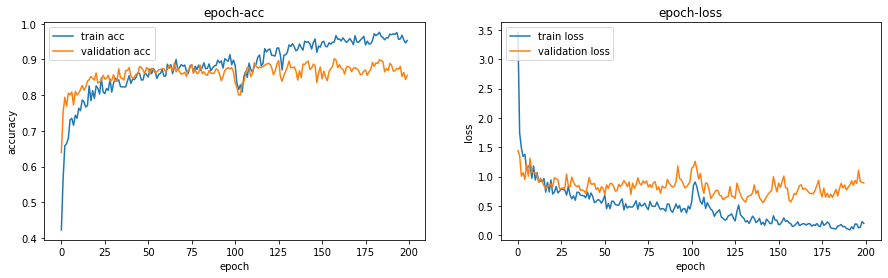

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(15,4))

ax[0].plot(acc)
ax[0].plot(val_acc)
ax[0].legend(['train acc','validation acc'],loc='upper left')
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("accuracy")
ax[0].set_title("epoch-acc")

ax[1].plot(loss)
ax[1].plot(val_loss)
ax[1].legend(['train loss','validation loss'],loc='upper left')
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("loss")
ax[1].set_title("epoch-loss")
plt.show()

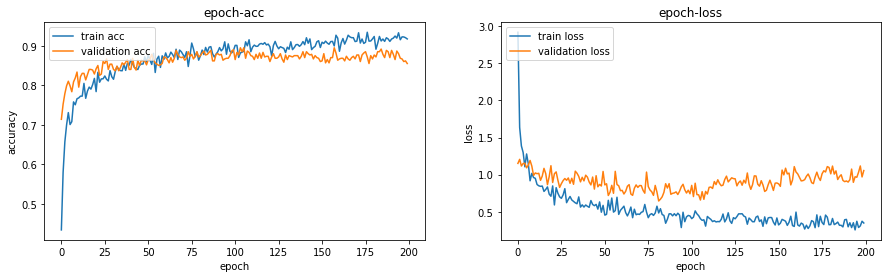

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(15,4))

ax[0].plot(history.history['acc'])
ax[0].plot(history.history['val_acc'])
ax[0].legend(['train acc','validation acc'],loc='upper left')
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("accuracy")
ax[0].set_title("epoch-acc")

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].legend(['train loss','validation loss'],loc='upper left')
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("loss")
ax[1].set_title("epoch-loss")
plt.show()

## confusion matrix

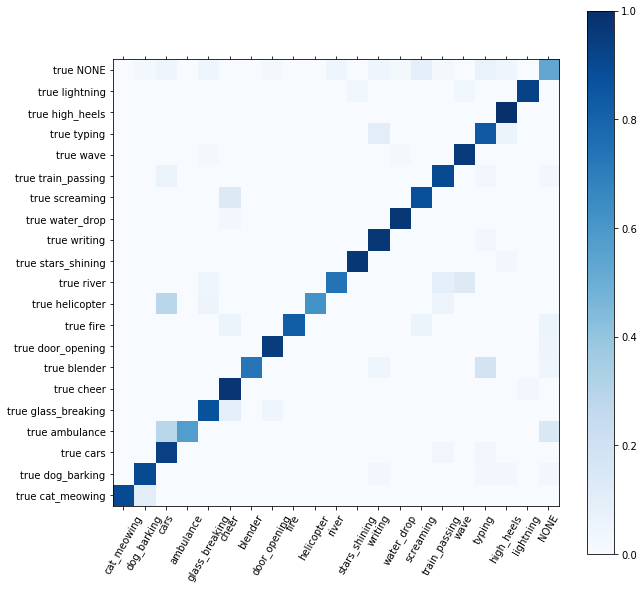

In [ ]:
#@title plot
# confusion matrix like:
def conf_matr(x,y,model,prt=True):
    yp=model.predict(x)
    matrix = np.zeros((len(y[0]),len(y[1])))
    for i in range(len(x)):
        matrix[y[i].argmax()][yp[i].argmax()]+=1
    for i in range(len(y[0])):
        cnt=0
        matrix[i]/=np.sum(matrix[i])
    if prt:
        plt.figure(figsize=(10,10)).patch.set_alpha(0)
        pcm=plt.matshow(matrix, fignum=0, norm=colors.Normalize(vmin=0, vmax=1), cmap=cm.Blues)
        plt.xticks(np.arange(len(matrix)), [i for i in fn], rotation=60)
        plt.tick_params(labeltop=False, labelbottom=True)
        plt.ylim(-0.5,len(matrix)-0.5)
        plt.yticks(np.arange(len(matrix)), ['true '+i for i in fn])
        plt.colorbar(pcm)
        plt.show()
    return matrix
mat = conf_matr(x_test,y_test,model)

In [ ]:
print(mat)

# classify function

In [ ]:
def classify(file,prt=True):
    if type(file)==str:
        source = mpimg.imread(file)
        new=resize(source).reshape(1,siz,siz,3)
    else:
        new=resize(file).reshape(1,siz,siz,3)
    if prt:
        plt.imshow(new[0])
        plt.axis('off')
        plt.show()
    ans = model.predict(new)
    return fn[ans.argmax()]

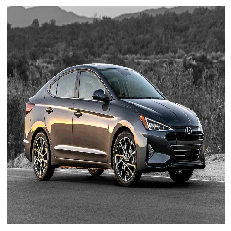

'cars'

In [ ]:
classify('/content/car.jpg')

In [ ]:
# cnt,num=0,0
# for i in range(len(x_test)):
#     num+=1
#     a,b=fn[y_test[i].argmax()],classify(x_test[i])
#     print('expect: ',a,'\t\t\tget: ',b)
#     if a==b:
#         cnt+=1
# print(cnt*100/num,"%")

# ROC curve

1000/1000 [==============================] - 5s 5ms/step


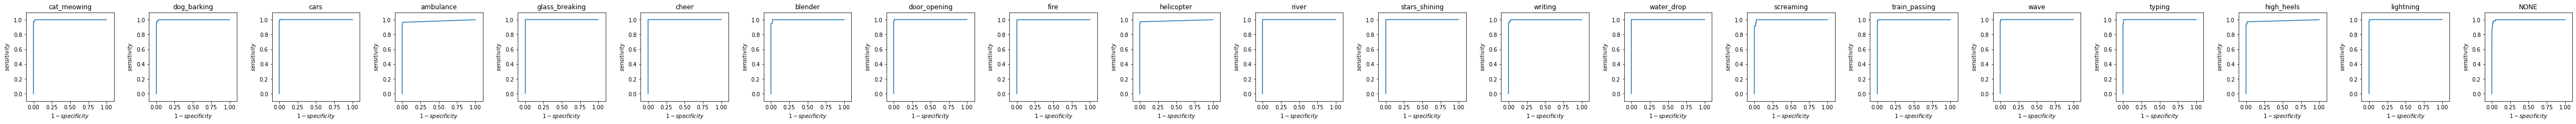

In [ ]:
def getROC(y,yp,thr,ind):
    TP,TN,FP,FN=0,0,0,0
    for i in range(len(y)):
        res=bool(yp[i][ind]>=thr)
        ans=bool(y[i][ind]==1)
        if res==True and ans==True:
            TP+=1
        elif res==True and ans==False:
            FP+=1
        elif res==False and ans==True:
            FN+=1
        elif res==False and ans==False:
            TN+=1
    return TP,TN,FP,FN

def roc(x,y,model,aug=True):
    eps=1e-10
    fig,ax=plt.subplots(1,num_classes,figsize=(4*num_classes,3))
    plt.subplots_adjust(wspace=0.4)
    if aug:
        gen=generator()
        gen.fit(x)
        x,y=next(gen.flow(x,y,batch_size=1000))
        yp=model.predict(x,verbose=1)
    else:
        yp=model.predict(x,verbose=1)
    area=[]
    for i in range(len(fn)):
        ax[i].set_title(fn[i])
        ax[i].set_xlabel('$1-specificity$')
        ax[i].set_ylabel('$sensitivity$')
        ax[i].set_xlim(-0.1,1.1)
        ax[i].set_ylim(-0.1,1.1)
        X,Y=[],[]
        t=0
        lastx,lasty=1,1
        for thr in np.linspace(-eps,1+eps,1000):
            TP,TN,FP,FN=getROC(y,yp,thr,i)
            X.append(FP/(FP+TN))
            Y.append(TP/(TP+FN))
            t+=(lasty+(TP/(TP+FN)))*(lastx-FP/(FP+TN))/2
            lastx,lasty=FP/(FP+TN),TP/(TP+FN)
        area.append(t)
        ax[i].plot(X,Y)
    return X,Y,area
    # plt.show()
    for i in range(len(fn)):
        print(f'{fn[i]}: {area[i]}')

x,y,a=roc(x_train,y_train,model)

In [ ]:
plt.figure(figsize=(5,5))
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x,y)
plt.legend(['AUC: %.3f'%(a[-1])])
plt.show()

# heatmap

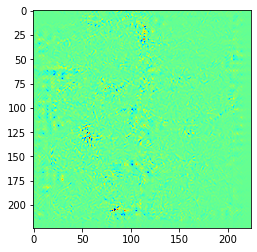

In [ ]:
def heatmap(model):
    input_img=model.inputs[0]
    loss=[K.mean(model.outputs[0][0][i]) for i in range(model.outputs[0].shape[1])]
    func=[K.function([input_img],[K.mean(K.gradients(loss[i],input_img)[0],axis=3)]) for i in range(model.outputs[0].shape[1])]
    def f(img):
        ind=model.predict([[img]])[0].argmax()
        img_tensor=K.constant(np.array([img]))
        return func[ind]([img_tensor])[0].reshape(model.inputs[0].shape[1:3])
    return f
f=heatmap(model)
plt.imshow(f(x_train[0]),cmap='jet')
plt.show()

In [ ]:
for ind in range(20):
    plt.imshow(f(x_train[ind]),cmap='jet')
    plt.colorbar()
    plt.show()
    plt.imshow(x_train[ind])
    plt.show()